
Select a month of data from the Indiegogo dataset at https://webrobots.io/indiegogo-dataset/. You can choose whether to load the json.gz files or deal with the zips of CSV files. You may need to research how to use R/Python to read the gz compression or unzip the file.

If you do not get at least 15,000 rows of data, select a second month and combine it with the first file.

Finally, select only the feature named “title” (you can discard all other features).


**------------------------Q1 Answer:------------------------**

I requested the data from the url https://webrobots.io/indiegogo-dataset/ and used BeautifulSoup to parse the html in order to retrieve the links for the json.gz files. 

I decided on the most recent dataset (2022-03-25). Then I 
1. Read in the data - using `requests.get(url).content`
2. Decompressed the packaged file - `from gzip import decompress`
3. decoded it - `decode("utf-8")`


> As I am reading it line by line, I only parsed it and only fetched `Title` column. I have a total of 68664 titles. 

**------------------------Q1 Code:------------------------**

In [165]:
import requests
from bs4 import BeautifulSoup

In [166]:
url = 'https://webrobots.io/indiegogo-dataset/'

webpage = requests.get(url)
soup = BeautifulSoup(webpage.text, 'html.parser')

In [167]:
datafiles = [a['href'] for a in soup.find_all('a', href = True) if '.json.gz' in a['href']]
datafiles[:5]

['https://s3.amazonaws.com/weruns/forfun/Indiegogo/Indiegogo_2022-03-25T20_40_41_780Z.json.gz',
 'https://s3.amazonaws.com/weruns/forfun/Indiegogo/Indiegogo_2022-02-11T20_40_44_295Z.json.gz',
 'https://s3.amazonaws.com/weruns/forfun/Indiegogo/Indiegogo_2022-01-21T20_40_42_239Z.json.gz',
 'https://s3.amazonaws.com/weruns/forfun/Indiegogo/Indiegogo_2021-12-10T20_40_47_580Z.json.gz',
 'https://s3.amazonaws.com/weruns/forfun/Indiegogo/Indiegogo_2021-11-19T20_40_48_076Z.json.gz']

In [168]:
data_url = datafiles[0]
data_url

'https://s3.amazonaws.com/weruns/forfun/Indiegogo/Indiegogo_2022-03-25T20_40_41_780Z.json.gz'

In [169]:
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

In [170]:
from gzip import decompress
from json import loads

In [171]:
def get_clean_data(url):
    data = decompress(requests.get(url).content).decode("utf-8")
    list_data = data.split('}}')
    title =[]
    for record in list_data[0:-1]:
        try:
            record = record + '}}'
            record = record.replace(':false', ':"False"').replace(':null', ':"Null"').replace(':true', ':"True"')
            record = eval(record)
            title.append(record.get('data').get('title'))
        except:
            print(record)
            breakpoint()
    return title

In [172]:
titles=get_clean_data(data_url)
len(titles)

68664

### 2.1 Pre-process the text - basic cleaning

**------------------------2.1 Answer------------------------**

This step is for *Basic* text preprocessing with nltk modules. I applied the following techniques:

For each title, I split it into words and applied the following before concatenating the words back. 
1. First I checked if it is an ENGLISH word using `enchant.Dict("en_US")
2. Then I removed stopwords using `from nltk.corpus import stopwords`
3. Removed words of len <= 2
4. Removed numeric words e.g. `type(12) is string`
5. Applied `from nltk.stem import PorterStemmer`


Next, I randomly set seed and randomly selecte 15000 titles. 
* `random.seed(12345)`
* `selected_titles = random.choices(titles, k=15000)`

Finally, I have returned 15000 rows of cleaned text titles. 5016 of the documents titles after cleaning is ' '. Based on Office Hour/ Saturday Discussion, we want to keep these as a cluster.

**------------------------2.1 Code------------------------**

In [174]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.stem import PorterStemmer
#from nltk.corpus import words # too slow
import enchant 
d = enchant.Dict("en_US") 
#import nltk.data 

In [175]:
stop_words = set(stopwords.words('english'))
word_tokenize_nopunct = RegexpTokenizer(r'\w+').tokenize
ps = PorterStemmer()

In [176]:
def clean_text(title_list):
    title_cleaned = []
    for title_i in title_list:
        title_token = word_tokenize_nopunct(title_i)
        build_back_title = []
        for word in title_token: 
            word = word.lower()
            try:
                if d.check(word):
                    if word in stop_words:
                        word = ''
                    if len(word) <= 2:
                        word = ''
                    if word.isnumeric():
                        word = ''
                    word = ps.stem(word)
                    build_back_title.append(word)
            except:
                pass
        while("" in build_back_title):
            try:
                build_back_title.remove("")
            except:
                pass
        title = ' '.join(build_back_title)
        title_cleaned.append(title)
    return title_cleaned

In [177]:
titles[:10]

['Learning in Quarantine using LEGO SERIOUS PLAY',
 'Emergency Surgery for Alonso. Cirugía de urgencia',
 'Pollinate the Peninsula',
 'Nature Knows Best',
 'The SADA Project',
 'The Harmonic Egg is Coming to Long Island!',
 'Equipment Sponsorship & Capital Fundraiser',
 'Pre Order 2nd Edition of Lighter: Living Tantra',
 'United States Happiness Report',
 'Path to Peru']

***reduced number of rows by randomly selecting 15000 rows***

In [178]:
import random
random.seed(12345)
selected_titles = random.choices(titles, k=15000)

In [179]:
%time cleaned_title = clean_text(selected_titles)

CPU times: user 3.87 s, sys: 1.3 s, total: 5.17 s
Wall time: 6.62 s


In [180]:
len(cleaned_title)


15000

In [181]:
len(set(cleaned_title))

9984

In [182]:
len(cleaned_title) -len(set(cleaned_title))

5016

In [183]:
cleaned_title[:10]

['build new bike pirat workspac',
 'gong essenti daili practic set chi yoga medit',
 'patchwork monkey',
 '',
 'right know day',
 'make music way anytim anywher',
 'journey first mar surviv onlin game',
 'sun wind advertis wind',
 'post alcohol recoveri',
 'glass keep eye road']

***


### 2.2  Creating DTM - with original cleaned titles

**------------------------2.2 Answer------------------------**

I used `sklearn.feature_extraction.text import TfidfVectorizer` to create a dtm on my list of titles. 

1. I created a "vectorizer" using default values. 
2. Then I applied `fit_transform()` to my list of titles. 
3. Finally, I put it into a pandas dataframe using `pd.DataFrame(arrays, feature_names(words))`

However I had too many words. I had 5843 distinct words! So I explored other methods to reduce the number of words. 


**------------------------2.2 Code:------------------------**

In [184]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
vectorizer = TfidfVectorizer()

In [185]:
doc_vec = vectorizer.fit_transform(cleaned_title)
dtm = pd.DataFrame(doc_vec.toarray(), columns = vectorizer.get_feature_names())
dtm

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,abandon,abey,abil,aboard,aborigin,abort,abridg,abroad,absolut,abstract,...,zinc,zine,zing,zipper,zodiac,zombi,zone,zoo,zoom,zooplankton
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**------------------------2.2 Reduce Word Count - Ideas:------------------------**

1. Method 1 - Histogram (Selected this method for the homework. See the code in the following section)
    * Created a Histogram
    * Applied Box-Cox transformation
    * Tried to filtered out words that have frequency of beyond x standard deviation. This removed a lot of noise words. 
        * Tested 3 standard deviation, 2, and 1. Note that the the graph is heavily skewed right which means variance is highly sensitive. So I applied this boundary cutoff on the Box-Cox transformation. 
        
        

2. Method 2 - Testing SVD (***Appendix Section at the end.***)
    * Did not end up using for the model because I do not totally understand the concepts in SVD, such as the components, eigenvalues, eigenvectors, or Left and Right Covariance Matrix Transformations. 


3. Method 3 - Synonyms (***Appendix Section at the end.***) 
    * Reduced number of words. 
    * problem: lost of semantics in the words because of poor implementation on my end. 
    * used `from nltk.corpus import wordnet` follow by `word = sorted(wordnet.synsets(word)[0].lemmas())[0].name()`


4. Method 4 - Bigram (***Appendix Section at the end.***)
    * `vectorizer = TfidfVectorizer( stop_words='english', ngram_range=(2,2))`
    * problem: introduced more words. Believe this might increase accuracy of the model though. 

**------------------------2.2 Reduced Word Count - Code:------------------------**

### Method 1 - Histogram


1. Get frequency for each word
2. Create Histogram
3. Set cutoffs for words that has no predictive power
    * too frequent 
    * not frequent enough

***Step1: Get Word Freq***

In [186]:
import collections

In [187]:
def get_word_freq(data):
    word_freq= {}
    for col in data.columns:
        freqDict = collections.Counter(data[col])
        word_freq[col] = len(cleaned_title)-freqDict.get(0.0)
    return word_freq

In [188]:

%time freq_dtm = get_word_freq(dtm)


CPU times: user 42.9 s, sys: 1.26 s, total: 44.2 s
Wall time: 47.9 s


In [189]:
len(freq_dtm)

5843

***Step2: Histogram***

In [190]:
import seaborn as sns
import matplotlib.pyplot as plt

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


[Text(0.5, 1.0, 'Word Freq')]

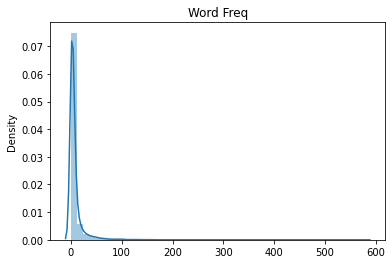

In [191]:
sns.distplot(list(freq_dtm.values())).set(title ='Word Freq')

**Hight concentration around 0. Super skewed right. Remove words that have count < 15 which is 1% of the documents**

In [192]:
bound = 0.01 * 1500

In [193]:
len(freq_dtm)

5843

In [194]:
# noise
noise_words_onepercent= {key: val for key, val in freq_dtm.items() if val < bound}

# not noise
freq_dtm= {key: val for key, val in freq_dtm.items() if val >= bound}

list(freq_dtm)[:10]

['access',
 'accessori',
 'act',
 'action',
 'activ',
 'adapt',
 'advanc',
 'adventur',
 'afford',
 'age']

In [195]:
list(noise_words_onepercent)[:10]

['abandon',
 'abey',
 'abil',
 'aboard',
 'aborigin',
 'abort',
 'abridg',
 'abroad',
 'absolut',
 'abstract']

In [196]:
from scipy import stats
import numpy as np

In [197]:
word_freq = list(freq_dtm.values())
transformed_wd_freq = stats.boxcox(word_freq)

In [198]:
upperbound = np.mean(transformed_wd_freq[0]) + np.std(transformed_wd_freq[0])
lowerbound = np.mean(transformed_wd_freq[0]) - np.std(transformed_wd_freq[0])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


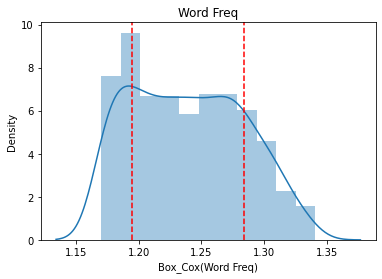

In [199]:

ax = sns.distplot(list(transformed_wd_freq[0]))
ax.set(title ='Word Freq')
ax.set_xlabel('Box_Cox(Word Freq)')
plt.axvline(x = upperbound, color = 'r', linestyle = '--')
plt.axvline(x = lowerbound, color = 'r', linestyle = '--')

In [200]:
len(transformed_wd_freq[0])

704

In [201]:
print('upperbound = '+ str(upperbound))

upperbound = 1.2839896814419027


In [202]:
print('lowerbound = '+ str(lowerbound))

lowerbound = 1.1945974126370256


Looking at the graph of the distribution. I will be removing words that are beyond 2 standard deviation - 95% of the data is within this boundary. 

Note that this is a DENSITY PLOT not a PDF.
 
The difference is the probability density is the probability per unit on the x-axis.  y-axis on a density plot as a value only for relative comparisons between different categories.

***Step 3: Finding the words to remove***

1. create a new dictionary - for each word (key), the value = boxcox(freq) value instead
2. identify significant_words
3. identify noise_words (add to text cleaning - prior to creating the dtm)


In [203]:
transformed_word_dict = dict(zip(freq_dtm.keys(), transformed_wd_freq[0]))
#print(len(transformed_word_dict))

significant_words = {key:val for key, val in transformed_word_dict.items() if (val >= lowerbound)& (val <= upperbound)}
noise_words = {key:val for key, val in transformed_word_dict.items() if (val > upperbound) | (val < lowerbound)}


In [204]:
# checks
len(transformed_word_dict) == len(significant_words) + len(noise_words)

True

In [205]:
len(noise_words)

293

In [206]:
print('Examine list of noise words')
list(noise_words.items())[:10]

Examine list of noise words


[('act', 1.1864229439352878),
 ('adventur', 1.3081490795053041),
 ('air', 1.2985585270452595),
 ('album', 1.3266798253399097),
 ('amp', 1.1702643971245135),
 ('ancient', 1.1933193942187803),
 ('angel', 1.1702643971245135),
 ('anniversari', 1.1787828334641481),
 ('app', 1.3240083681252452),
 ('apparel', 1.1864229439352878)]

In [207]:
print('Examine list of significant words')
list(significant_words.items())[:10]

Examine list of significant words


[('access', 1.2435785150656593),
 ('accessori', 1.1995801572489875),
 ('action', 1.2732597470156126),
 ('activ', 1.2347051689659025),
 ('adapt', 1.240798395596487),
 ('advanc', 1.2378463982570287),
 ('afford', 1.2732597470156126),
 ('age', 1.2153496794274519),
 ('aid', 1.2347051689659025),
 ('android', 1.2313548700972725)]

***Step 4: Apply noise word logic to text cleaning***

In [208]:
def remove_noise_words(titles_list, noise_words_list):
    cleaned_titles = []
    for title in titles_list:
        for word in title.split():
            build_back_title = []
            if word in noise_words_list:
                word = ''
            build_back_title.append(word)
        title = ' '.join(build_back_title)
        cleaned_titles.append(title)
    print('# of Titles = '+str(len(cleaned_titles)))
    return cleaned_titles

In [209]:
# adding two list of noise words
noise_wds = list(noise_words_onepercent.keys())
noise_wds.append(list(noise_words.keys()))
#noise_wds

In [210]:
# cleaned_title -  preprocessed list of titles extracted from source. 

%time no_noise_titles = remove_noise_words(cleaned_title, noise_wds)

# of Titles = 15000
CPU times: user 6.44 s, sys: 110 ms, total: 6.55 s
Wall time: 8.43 s


In [211]:
# Checks
len(no_noise_titles) == len(cleaned_title)

True

***Step 5: Creating New DTM***

In [212]:
vectorizer = TfidfVectorizer()
title_vec = vectorizer.fit_transform(no_noise_titles)
dtm_hist = pd.DataFrame(title_vec.toarray(), columns = vectorizer.get_feature_names())
dtm_hist

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,access,accessori,act,action,activ,adapt,advanc,adventur,afford,age,...,within,women,wooden,work,world,write,year,yoga,youth,zero
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0



# 3.	(20 points) 

Implement a hierarchical clustering algorithm of your choosing.

**------------------------3 Answer:------------------------**

1. First I calculated the cosine_similarity of the dtm. 
2. Then I calculated the distance matrix 
3. Finally, I applied hierarchical clustering methods using `from scipy.cluster import hierarchy`
    * 3a. divisive: `hierarchy.linkage(distance matrix)` + dendrogram.
    * 3b. agglomerative: `AgglomerativeClustering(distance_threshold=10, n_clusters=None)` 
        * no dendrogram here because it took too long to run. 

**------------------------3 Code:------------------------**



***First Need to Create a Distance Matrix - Cosine Similarity***

In [213]:
from sklearn.metrics.pairwise import cosine_similarity
%time dist_hist = 1 - cosine_similarity(dtm_hist)

CPU times: user 18.9 s, sys: 8.98 s, total: 27.9 s
Wall time: 30.6 s


In [261]:
set(dtm.iloc[0,:])

{0.0, 0.46509029850239786, 0.4864610464859512, 0.522994581468462}

***3a. Divisive with cosine similarity's distance matrix***

In [214]:
 
dist_matrix = pd.DataFrame(dist_hist)

In [215]:
from matplotlib import pyplot as plt
from scipy.cluster import hierarchy

%time Z = hierarchy.linkage(dist_matrix)


CPU times: user 25min 40s, sys: 23min 33s, total: 49min 13s
Wall time: 1h 25min 59s


Text(0.5, 1.0, 'Divisive Hierarchical Clustering')

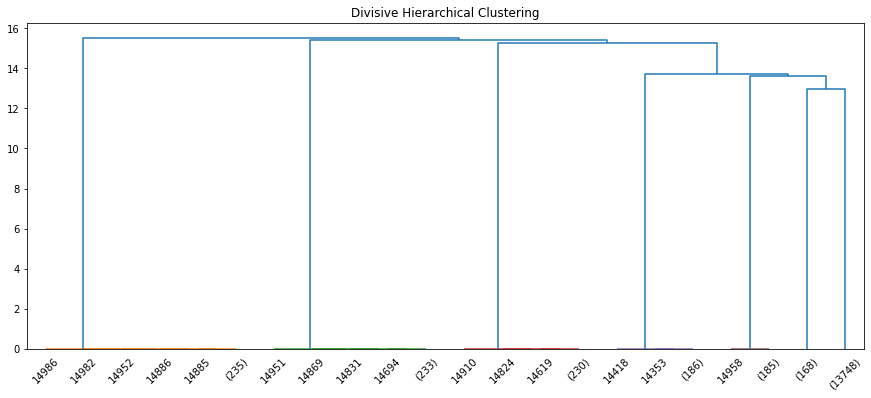

In [216]:
fig = plt.figure(figsize = (15, 6))
dn = hierarchy.dendrogram(Z, truncate_mode = 'level', p=5, leaf_rotation=45, leaf_font_size=10, 
                          labels = dist_matrix.index, color_threshold=3)
plt.title('Divisive Hierarchical Clustering')

***3b. Agglomerative***

In [217]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram

# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=10, n_clusters=None)

%time model = model.fit(dist_matrix)
model

CPU times: user 20min 44s, sys: 38.9 s, total: 21min 23s
Wall time: 22min 47s


AgglomerativeClustering(distance_threshold=10, n_clusters=None)

***This takes too long to run!***

In [218]:

# #https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html

# def plot_dendrogram(model, **kwargs):
#     # Create linkage matrix and then plot the dendrogram

#     # create the counts of samples under each node
#     counts = np.zeros(model.children_.shape[0])
#     n_samples = len(model.labels_)
#     for i, merge in enumerate(model.children_):
#         current_count = 0
#         for child_idx in merge:
#             if child_idx < n_samples:
#                 current_count += 1  # leaf node
#             else:
#                 current_count += counts[child_idx - n_samples]
#         counts[i] = current_count

#     linkage_matrix = np.column_stack(
#         [model.children_, model.distances_, counts]
#     ).astype(float)

#     # Plot the corresponding dendrogram
    
#     fig = plt.figure(figsize = (15, 6))
#     dendrogram(linkage_matrix, **kwargs)
#     plt.title("Hierarchical Clustering Dendrogram")
#     # plot the top three levels of the dendrogram
# #    plot_dendrogram(model, truncate_mode="level", p=20)
#     plt.xlabel("Number of points in node (or index of point if no parenthesis).")
#     plt.show()

In [219]:
# %time plot_dendrogram(model, truncate_mode="level", p=5)


**------------------------4 Answer:------------------------**

I used the silhouette score to determine how many cluster I should use. The higher the score the better the model. 

Because Birch hierarchical clustering algorithm is much faster, ran the distance matrix with this model several time under different number of clusters. 

The number of clusters that returned the best output is 4. 

**------------------------4 Code:------------------------**

In [220]:
df = dist_hist

In [221]:
brc = Birch(branching_factor = 50, threshold = 0.5,  n_clusters=2)
brc_model = brc.fit(df)
brc_result = brc.predict(df)

In [222]:
from sklearn.metrics import silhouette_samples, silhouette_score


In [223]:
range_n_clusters = [2, 3, 4, 5, 6, 10, 15, 25, 30]
k_bir_sil = {}

for n_clusters in range_n_clusters:
    clusterer = Birch(n_clusters=n_clusters)
    cluster_labels = clusterer.fit_predict(df)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters

    silhouette_avg = silhouette_score(df, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )
    k_bir_sil[n_clusters]=silhouette_avg
    

For n_clusters = 2 The average silhouette_score is : 0.6061651496261511
For n_clusters = 3 The average silhouette_score is : 0.6252017742889926
For n_clusters = 4 The average silhouette_score is : 0.6433827866062412
For n_clusters = 5 The average silhouette_score is : 0.6253813391297037
For n_clusters = 6 The average silhouette_score is : 0.6402861343667355
For n_clusters = 10 The average silhouette_score is : 0.6105582200855076
For n_clusters = 15 The average silhouette_score is : 0.6030840862469787
For n_clusters = 25 The average silhouette_score is : 0.6004826916014743
For n_clusters = 30 The average silhouette_score is : 0.48361786431567855


In [224]:
fin_max = max(k_bir_sil, key=k_bir_sil.get)
print("Number of Clusters with the Highest Silhouette Score = "+ str(fin_max))

Number of Clusters with the Highest Silhouette Score = 4




Visualize the article clustering results in a dendrogram or heatmap. Please be sure to show a clean dendrogram and not a sloppy dendrogram. Delivering an imbalanced unclear dendrogram, or a heatmap with too small text, will result in reducing your grade. You might consider finding out how to only show one branch per cluster (rather than one branch per observation). 



**------------------------5 Answer:------------------------**

Q4 returned the best number of cluster (=4) and I fed this into the Divisive Hierarchical Clustering dendrogram. 

`trucate_mode = 'lastp'` and `p = fin_max` where fin_max = number of cluster with the best silhouette Score. 

**------------------------5 Code:------------------------**

In [225]:
#%time Z = hierarchy.linkage(dist_matrix.iloc[:,:100])


Text(0.5, 1.0, 'Divisive Hierarchical Clustering')

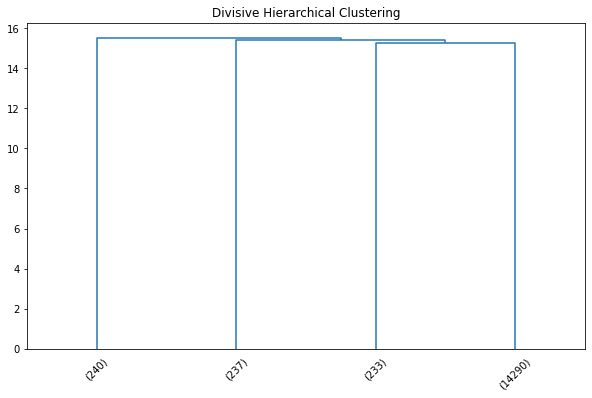

In [226]:
fig = plt.figure(figsize = (10, 6))

dn = hierarchy.dendrogram(Z, truncate_mode = 'lastp', p=fin_max, leaf_rotation=45, leaf_font_size=10, 
                          labels = dist_matrix.index)
plt.title('Divisive Hierarchical Clustering')

***

# APPENDIX

1. Testing SVD
2. Synonyms
3. DTM - Bigram

### 1. Testing SVD

In [229]:
from sklearn.decomposition import TruncatedSVD

In [230]:
svd = TruncatedSVD(n_components=200, n_iter=7, random_state=42)
svd.fit(dtm_hist)

TruncatedSVD(n_components=200, n_iter=7, random_state=42)

In [231]:
svd.explained_variance_ratio_.sum()

0.712949106807215

In [232]:
svd.n_features_in_

650

In [233]:
pd.DataFrame(svd.components_)

,0,1,2,3,4,5,6,7,8,9,...,640,641,642,643,644,645,646,647,648,649
0,2.222993e-16,4.975201e-12,-4.193316e-16,7.378695e-12,5.010880e-13,-1.832064e-12,-2.562376e-19,2.427797e-15,-2.525145e-13,-8.536568e-14,...,1.476183e-14,6.474357e-14,6.861770e-17,1.229084e-11,-3.926904e-16,-2.798507e-20,-7.659820e-14,1.013082e-11,-1.423338e-14,8.682839e-15
1,-2.049169e-17,7.480313e-12,-2.879340e-15,2.523662e-12,1.820280e-13,-1.182523e-12,9.429722e-19,-2.074779e-16,-1.189845e-12,4.272044e-13,...,-3.111288e-15,-1.731376e-13,-1.369770e-16,3.048469e-12,3.362726e-16,6.341692e-21,-3.845538e-14,1.628130e-11,1.316747e-14,-1.778024e-14
2,1.214405e-16,-4.365580e-12,-2.638322e-15,-9.220966e-12,1.299564e-14,5.461298e-13,3.406398e-19,-1.081879e-15,6.015732e-13,9.153659e-13,...,-8.671670e-15,-1.009887e-13,2.919478e-17,-2.233192e-13,1.979372e-16,1.282768e-20,2.564084e-13,-1.391082e-11,5.346482e-15,-2.331658e-15
3,-1.505235e-16,-7.009554e-11,1.279702e-14,3.149434e-11,-1.521327e-12,2.372353e-12,3.575644e-18,-2.526226e-14,-7.027691e-12,4.830634e-12,...,-5.908829e-14,3.015427e-13,1.790205e-15,-2.913795e-11,-1.396114e-15,-2.882845e-20,-2.538137e-12,2.731010e-11,-3.133345e-14,3.818991e-14
4,3.840367e-16,-4.374397e-11,2.313012e-15,-1.163540e-10,7.975789e-13,7.586499e-12,-2.255854e-18,-1.898332e-14,1.204643e-11,6.492091e-14,...,1.916047e-14,-4.905289e-13,-7.730567e-16,-5.530759e-11,1.112239e-15,-3.124763e-20,-1.477287e-12,4.648821e-11,1.306255e-15,-1.839629e-14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,-8.028063e-07,-5.456226e-02,5.905987e-06,-1.130648e-03,-6.225420e-03,-1.002089e-04,1.519204e-10,-1.184677e-07,8.804405e-03,-4.936996e-04,...,-3.291699e-05,-6.109044e-06,-7.201150e-07,-1.497145e-01,-9.033152e-09,3.207353e-12,-5.970221e-05,-2.521372e-03,-1.934204e-05,1.136554e-04
196,-2.243481e-07,-8.842557e-02,-2.216591e-06,3.120509e-02,-1.450862e-03,1.306059e-04,-1.375184e-11,9.900558e-08,-5.386804e-03,4.892805e-04,...,-1.254393e-04,1.377599e-05,1.469065e-07,5.420356e-02,1.541648e-08,5.758138e-11,1.445497e-04,5.359496e-04,-5.531578e-06,3.925145e-06
197,-1.041403e-06,-3.815723e-02,5.487183e-06,5.555555e-02,-1.089348e-02,5.781829e-04,7.629528e-11,1.236268e-07,-5.999873e-03,5.675028e-03,...,5.248301e-05,7.807801e-06,8.338706e-08,2.655141e-01,1.416134e-08,-2.808511e-10,-3.842179e-05,8.941035e-04,-5.643346e-06,1.433819e-04
198,-9.932603e-07,-1.431696e-02,1.378056e-05,-1.936791e-02,8.134218e-03,-4.733756e-04,9.219270e-11,1.077104e-07,-1.025977e-03,4.283655e-03,...,-1.721352e-04,2.189871e-05,-6.685291e-07,-1.293417e-01,1.267611e-08,-2.076707e-11,5.890238e-05,-1.433588e-01,1.975337e-04,2.089675e-05


***

### 2. Converting to synonyms - Idea (Did not end up using)

Lost of word semantics - not very helpful

In [234]:
from nltk.corpus import wordnet

In [235]:
subsettitle = cleaned_title[:15000]
#subsettitle

In [236]:
def convert_to_synonyms(data):
    data_sysn = []
    for title in data:
        build_back_title = []
        for word in title.split():
            
            w = get_synonyms(word)
            build_back_title.append(w)
        title =' '.join(build_back_title)
        data_sysn.append(title)
    return data_sysn

In [237]:
def get_synonyms(word):
    try:
        word = sorted(wordnet.synsets(word)[0].lemmas())[0].name()
    except:
        pass
    return word

In [238]:
%time sys_title = convert_to_synonyms(subsettitle)

CPU times: user 8.01 s, sys: 4.04 s, total: 12.1 s
Wall time: 18.4 s


***Testing if finding synonyms will reduce number of dimensions***

Trade-off lose semantics

In [239]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

vectorizer = TfidfVectorizer()
%time title_vec = vectorizer.fit_transform(subsettitle)
feat1= vectorizer.get_feature_names()

CPU times: user 161 ms, sys: 28.4 ms, total: 190 ms
Wall time: 253 ms


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [240]:
title_vec.shape

(15000, 5843)

In [241]:
%time title_vec2 = vectorizer.fit_transform(sys_title)
title_vec2.shape
feat2= vectorizer.get_feature_names()

CPU times: user 155 ms, sys: 18.9 ms, total: 174 ms
Wall time: 306 ms


In [242]:
title_vec2.shape

(15000, 5437)

In [243]:
# reduction in features: 
title_vec.shape[1] - title_vec2.shape[1]

406

In [249]:
dtm1 = pd.DataFrame(title_vec2.toarray(), columns = feat2)
dtm1

,10,1000,1000000,1000000000000,12,13,14,15,19,21,...,zealot,zen,zenith,zine,zing,zn,zodiac,zombi,zone,zooplankton
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [252]:
#set(feat1).difference(set(feat2))

Conclusion: 

Might come back to test using synonyms to rate clustering performance, but right now the words don't look right. I'm removing semantics and introducing numbers. I am only looking at the first word from the list of synonyms which is not the best approach. 

### 3. Getting DTM - Bigram

In [253]:

from sklearn.feature_extraction.text import TfidfVectorizer

#define vectorizer parameters
vectorizer = TfidfVectorizer( stop_words='english',
                                  ngram_range=(2,2))



In [254]:
doc_vec = vectorizer.fit_transform(cleaned_title)
dtm = pd.DataFrame(doc_vec.toarray(), columns = vectorizer.get_feature_names())
dtm

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,abandon hous,abey fring,abil awar,abil order,abil time,aborigin entrepreneur,abort right,abroad adventur,abroad fund,abroad internship,...,zone temp,zone volum,zoo discoveri,zoo keeper,zoo king,zoo podcast,zoo tiger,zoo tycoon,zoom len,zooplankton art
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
